In [2]:
!pip install yfinance

In [3]:
import yfinance as yf # yahoo finance 套件
import pandas as pd # 結構化資料處理套件
import datetime as dt # 時間套件

In [4]:
# 輸入股票代號
stock_id = "3708.tw"
'''今天往前算幾天'''
# 資料結束時間
end = dt.date.today()
# 抓取半年資料(現在-過取180天)
start = end - dt.timedelta(days=180)

# 參數1: 股票代號, 參數2: 開始時間, 參數3: 結束時間
df = yf.download(stock_id, start=start, end=end).reset_index()

# 刪除 Ticker 欄位並取代
df.columns = df.columns.droplevel('Ticker')

df


/tmp/ipython-input-2081871013.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(stock_id, start=start, end=end).reset_index()
[*********************100%***********************]  1 of 1 completed


Price,Date,Close,High,Low,Open,Volume
0,2025-03-25,79.257690,81.193165,79.160918,81.193165,207274
1,2025-03-26,79.257690,79.838331,79.064139,79.257690,141031
2,2025-03-27,79.160919,79.354464,78.580271,79.257691,144023
3,2025-03-28,76.644791,79.160914,75.580281,79.160914,694591
4,2025-03-31,69.193214,73.644804,69.193214,73.644804,1468038
...,...,...,...,...,...,...
119,2025-09-15,119.500000,122.500000,116.000000,118.500000,4296564
120,2025-09-16,117.000000,122.500000,117.000000,120.000000,3861419
121,2025-09-17,113.500000,117.500000,113.000000,116.000000,1666500
122,2025-09-18,114.500000,115.500000,112.000000,115.500000,1291170


# **1.1技術指標的計算**
 MA、RSI、MACD

In [5]:
# 計算8日 SMA
df['SMA8'] = df['Close'].rolling(window=8).mean()
# 計算13日 SMA
df['SMA13'] = df['Close'].rolling(window=13).mean()
# 計算20日 SMA
df['SMA20'] = df['Close'].rolling(window=20).mean()

# 列印最後筆數
df.tail()

Price,Date,Close,High,Low,Open,Volume,SMA8,SMA13,SMA20
119,2025-09-15,119.5,122.5,116.0,118.5,4296564,115.8125,121.538462,126.050
120,2025-09-16,117.0,122.5,117.0,120.0,3861419,115.9375,120.461538,125.650
121,2025-09-17,113.5,117.5,113.0,116.0,1666500,115.7500,118.115385,125.175
122,2025-09-18,114.5,115.5,112.0,115.5,1291170,115.5625,116.923077,124.150
123,2025-09-19,116.0,117.5,113.5,115.5,1912307,116.0000,116.115385,122.525


# MACD + RSI (判斷買賣點)

In [6]:
# 12日 EMA
df['EMA12'] = df['Close'].ewm(span=12, adjust=False).mean()
# 26日 EMA
df['EMA26'] = df['Close'].ewm(span=26, adjust=False).mean()

# DIF (快線) = EMA12 - EMA26
df['DIF'] = df['EMA12'] - df['EMA26']

# MACD = DIF 的9日 EMA (慢線:計算出DIF後，再取DIF的N日指數移動平均線EMA(一般使用9日天數)即得)
df["MACD"] = df["DIF"].ewm(span=9, adjust=False).mean()

# OSC (柱狀圖) = DIF - MACD
df["OSC"] = df["DIF"] - df["MACD"]

# ----------RSI-------------
# 計算每個交易日的價格變動，即當天收盤價與前一天收盤價的差異
df['Change'] = df['Close'].diff()

# 將變動值中的正數部分視為 "Gain" (增益)，如果變動為負則記為0
df['Gain'] = df['Change'].apply(lambda x: x if x > 0 else 0)

# 將變動值中的負數部分視為 "Loss" (損失)，取其絕對值，如果變動為正則記為0
df['Loss'] = df['Change'].apply(lambda x: abs(x) if x < 0 else 0)

# 計算過去14個交易日的平均增益
df['AvgGain'] = df['Gain'].rolling(window=14).mean()

# 計算過去14個交易日的平均損失
df['AvgLoss'] = df['Loss'].rolling(window=14).mean()

# 計算相對強弱指數的相對強度 (RS) ，即平均增益與平均損失的比值
df['RS'] = df['AvgGain'] / df['AvgLoss']

# 計算相對強弱指數 (RSI) ，使用 RS 公式計算出來
df['RSI'] = 100 - (100 / (1 + df['RS']))

# 刪除不需要的欄位
df.drop(['Change', 'Gain', 'Loss', 'AvgGain', 'AvgLoss', 'RS'], axis=1, inplace=True)

df



Price,Date,Close,High,Low,Open,Volume,SMA8,SMA13,SMA20,EMA12,EMA26,DIF,MACD,OSC,RSI
0,2025-03-25,79.257690,81.193165,79.160918,81.193165,207274,NaN,NaN,NaN,79.257690,79.257690,0.000000,0.000000,0.000000,NaN
1,2025-03-26,79.257690,79.838331,79.064139,79.257690,141031,NaN,NaN,NaN,79.257690,79.257690,0.000000,0.000000,0.000000,NaN
2,2025-03-27,79.160919,79.354464,78.580271,79.257691,144023,NaN,NaN,NaN,79.242803,79.250522,-0.007720,-0.001544,-0.006176,NaN
3,2025-03-28,76.644791,79.160914,75.580281,79.160914,694591,NaN,NaN,NaN,78.843108,79.057505,-0.214397,-0.044114,-0.170282,NaN
4,2025-03-31,69.193214,73.644804,69.193214,73.644804,1468038,NaN,NaN,NaN,77.358509,78.326817,-0.968308,-0.228953,-0.739354,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119,2025-09-15,119.500000,122.500000,116.000000,118.500000,4296564,115.8125,121.538462,126.050,119.873517,120.570987,-0.697470,1.472742,-2.170212,37.323944
120,2025-09-16,117.000000,122.500000,117.000000,120.000000,3861419,115.9375,120.461538,125.650,119.431437,120.306469,-0.875032,1.003187,-1.878219,39.849624
121,2025-09-17,113.500000,117.500000,113.000000,116.000000,1666500,115.7500,118.115385,125.175,118.518909,119.802286,-1.283378,0.545874,-1.829252,37.410072
122,2025-09-18,114.500000,115.500000,112.000000,115.500000,1291170,115.5625,116.923077,124.150,117.900615,119.409525,-1.508910,0.134917,-1.643827,24.347826


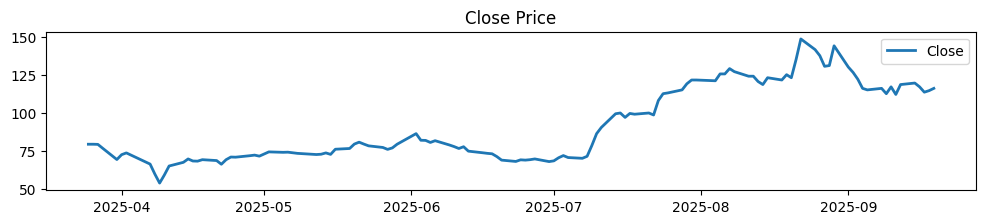

In [7]:
import matplotlib.pyplot as plt
# 繪圖
plt.figure(figsize=(12, 7))

# 收盤價
plt.subplot(3,1,1)
plt.plot(df["Date"], df["Close"], label="Close",linewidth=2)
plt.title("Close Price")
plt.legend()



plt.show()

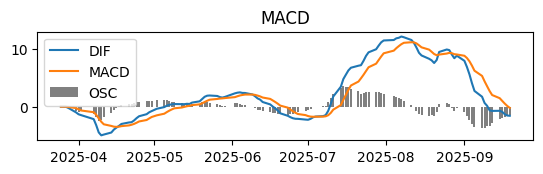

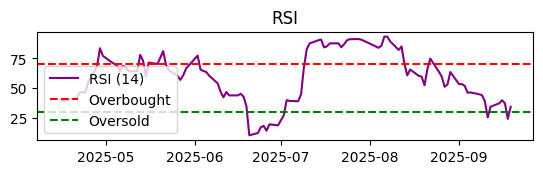

In [10]:

# MACD
plt.subplot(3,1,2)
plt.plot(df["Date"], df["DIF"], label="DIF")
plt.plot(df["Date"], df["MACD"], label="MACD")
plt.bar(df["Date"], df["OSC"], label="OSC", color="gray")
plt.title("MACD")
plt.legend()

plt.show()

# RSI
plt.subplot(3,1,3)
plt.plot(df["Date"], df["RSI"], label="RSI (14)", color="purple")
plt.axhline(70, color='red', linestyle='--', label='Overbought')
plt.axhline(30, color='green', linestyle='--', label='Oversold')
plt.title("RSI")
plt.legend()

plt.show()

# K 線

In [11]:
!pip install mplfinance

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 3.1 MB/s eta 0:00:00


In [12]:
# 將原始的 dataframe 在建立一個出來
kplot_df = df.set_index('Date')
kplot_df['2025-08-01':'2025-09-21'].tail()

Price,Close,High,Low,Open,Volume,SMA8,SMA13,SMA20,EMA12,EMA26,DIF,MACD,OSC,RSI
Date,,,,,,,,,,,,,,
2025-09-15,119.5,122.5,116.0,118.5,4296564,115.8125,121.538462,126.050,119.873517,120.570987,-0.697470,1.472742,-2.170212,37.323944
2025-09-16,117.0,122.5,117.0,120.0,3861419,115.9375,120.461538,125.650,119.431437,120.306469,-0.875032,1.003187,-1.878219,39.849624
2025-09-17,113.5,117.5,113.0,116.0,1666500,115.7500,118.115385,125.175,118.518909,119.802286,-1.283378,0.545874,-1.829252,37.410072
2025-09-18,114.5,115.5,112.0,115.5,1291170,115.5625,116.923077,124.150,117.900615,119.409525,-1.508910,0.134917,-1.643827,24.347826
2025-09-19,116.0,117.5,113.5,115.5,1912307,116.0000,116.115385,122.525,117.608213,119.156967,-1.548754,-0.201817,-1.346937,34.444444


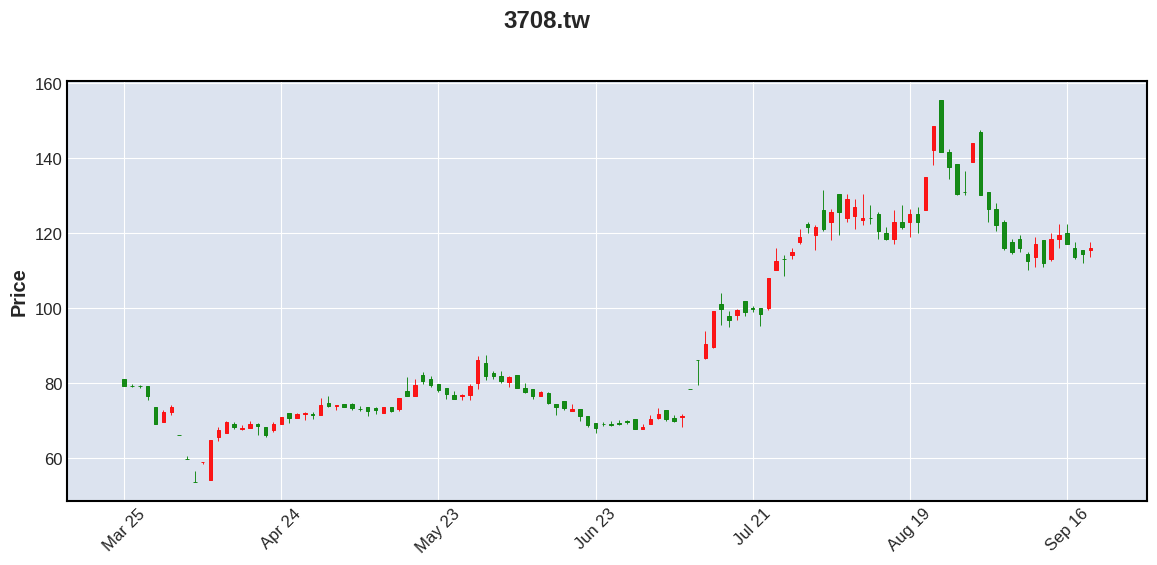

In [13]:
import mplfinance as mpf
# 設置繪圖風格
my_color = mpf.make_marketcolors(up='r', down='g', inherit=True)
my_style = mpf.make_mpf_style(base_mpf_style='default', marketcolors=my_color)

# 使用 mplfinance 繪製 K 線圖
mpf.plot(kplot_df, type='candle', style=my_style, title=f'{stock_id}', figsize=(15, 6))


In [14]:
import numpy as np  # 引入 numpy，用於數據處理和數值運算
from sklearn.model_selection import train_test_split  # 引入 train_test_split，用於將數據集拆分為訓練集和測試集
from sklearn.metrics import mean_squared_error  # 引入 mean_squared_error 用於評估模型性能

In [33]:
# 標籤: 預測未來5天的價格，舉例說明:用技術指標預測隔天的收盤價
n = 5
# 標籤: 隔日收盤價 > 當日收盤價 → 1 (漲)，否則 0 (跌)
df["Target"] = (df["Close"].shift(-1) > df["Close"]).astype(int)

# 去除缺失值
df.dropna(inplace=True)

features = ["DIF", "MACD", "OSC", "RSI"]
X = df[features].dropna()
y = df["Target"].dropna()

X.shape, y.shape

((90, 4), (90,))

In [34]:
# 將數據集 X 和標籤 y 拆分為訓練集和測試集
# test_size=0.2 表示測試集佔全部數據的 20% --> 80% 的資料作為訓練，20% 的資料作為測試
# shuffle=False 表示在拆分數據時不打亂原始數據的順序
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# 查看拆分後訓練集和測試集的形狀
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((72, 4), (18, 4), (72,), (18,))

# 線性回歸

In [35]:
# 引入線性回歸模型
from sklearn.linear_model import LinearRegression

# 建立並訓練線性回歸模型
model = LinearRegression()
model.fit(X_train, y_train)

# 預測
y_pred = model.predict(X_test)

# 評估
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f"線性回歸模型RMSE: {rmse:.2f}")

# 使用模型進行未來價格走勢預測
future_pred = model.predict(X[-1:])  # 使用最新的數據進行預測
print(f"線性回歸模型預測未來{n}天的價格: {future_pred[0]:.2f}")

線性回歸模型RMSE: 0.57
線性回歸模型預測未來5天的價格: 0.21


In [39]:
from sklearn.svm import SVC  # 引入 SVM 模型
# === 訓練 SVM 模型 ===
svm = SVC(kernel="rbf", C=1.0, gamma="scale")  # 常用 rbf kernel
svm.fit(X_train, y_train)

# === 預測 ===
y_pred = svm.predict(X_test)
y_pred
future_pred = model.predict(X.iloc[-1:])[0]
if future_pred == 1:
    print("模型預測: 明天收盤價可能上漲 📈")
else:
    print("模型預測: 明天收盤價可能下跌 📉")

模型預測: 明天收盤價可能下跌 📉
